In [72]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [73]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [74]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)


In [75]:
import torch 
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [76]:
RANDOM_SEED=42
BATCH_SIZE=512
EPOCHS=40


LEARNING_RATE=1e-4
NUM_CLASSES=10
PATH_SIZE=4
IMG_SIZE=28
IN_CHANNELS=1
NUM_HEADS=8
DROPOUT=0.001
HIDDEN_DIM=768
ADAM_WEIGHT_DECAY=0
ADAM_BETA=(0.9,0.999)
ACTIVATION = "gelu"
NUM_ENCODERS=4
EMBED_DIM=(PATH_SIZE **2)* IN_CHANNELS
NUM_PATCHES=(IMG_SIZE // PATH_SIZE)** 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False



device="cuda" if torch.cuda.is_available() else "cpu"



class PatchEmbedding(nn.Module):
    def __init__(self,embed_dim,path_size,num_pathes,dropout,in_channels):
        super().__init__()
        self.patcher=nn.Sequential(
            nn.Conv2d(
            in_channels=in_channels,
            out_channels=embed_dim,
            kernel_size=path_size,
            stride=path_size
            
        ),
        nn.Flatten(2))
        self.cls_token=nn.Parameter(torch.randn(size=(1,in_channels,embed_dim)),required_grad=True)
        self.position_embeddings=nn.Parameter(torch.randn(size=(1,num_pathes+1,embed_dim)),requires_grad=True)
        self.dropout=nn.Dropout(p=dropout)
    
    def forward(self,x):
        cls_token=self.cls_token.expand(x.shape[0],-1,-1)
        x=self.patcher(x).permute(0,2,1)
        x=torch.cat([cls_token,x],dim=1)
        x=self.dropout(x)
        return x
 model=PatcherEmbedding(EMBED_DIM,PA
        
        
        

In [77]:
class PatchEmbedding(nn.Module): 
    def __init__(self,embed_dim,path_size,num_pathes,dropout,in_channels): 
        super().__init__()
        self.patcher=nn.Sequential( 
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim, 
                kernel_size=path_size,
                stride=path_size

    ),
          nn.Flatten(2))
        self.cls_token=nn.Parameter(torch.randn(size=(1,in_channels,embed_dim)),requires_grad=True)
        self.position_embeddings=nn.Parameter(torch.randn(size=(1,num_pathes+1,embed_dim)),requires_grad=True)
        self.dropout=nn.Dropout(p=dropout)

    def forward(self,x):
        cls_token=self.cls_token.expand(x.shape[0],-1,-1)
        x=self.patcher(x).permute(0,2,1)
        x=torch.cat([cls_token,x],dim=1)
        x=self.position_embeddings+x
        x=self.dropout(x)
        return x
model=PatchEmbedding(EMBED_DIM,PATH_SIZE,NUM_PATCHES,DROPOUT,IN_CHANNELS).to(device)
x=torch.rand(512,1,28,28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


# 

In [78]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

torch.Size([512, 10])


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [79]:
train_df=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
submission_df=pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [80]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [83]:
train_df,val_df=train_test_split(train_df,test_size=0.1,random_state=RANDOM_SEED,shuffle=True)

In [84]:
train_df.shape

(37800, 785)

In [87]:
class MNISTTrainDataset(Dataset):
    def __init__(self,images,labels,indicies):
        self.images=images
        self.labels=labels
        self.indicies=indicies
        self.transform=transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
        
    def __len__(self):
        
        return len(self.images)
    def __getitem__(self,idx):
        image=self.images[idx].reshape((28,28)).astype(np.uint8)
        label=self.labels[idx]
        index=self.indicies[idx]
        image=self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self,images,labels,indicies):
        self.images=images
        self.labels=labels
        self.indicies=indicies
        self.transform=transforms.Compose([

            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        image=self.images[idx].reshape((28,28)).astype(np.uint8)
        label=self.labels[idx]
        index=self.indicies[idx]
        image=self.transform(image)
        
        return {"image": image ,"label":label,"index" : index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self,images,indicies):
        self.images=images
        self.indicies=indicies
        
  
        self.transform=transforms.Compose([

            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        image=self.images[idx].reshape((28,28)).astype(np.uint8)
     
        index=self.indicies[idx]
        image=self.transform(image)
        
        return {"image": image,"index" : index}


37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

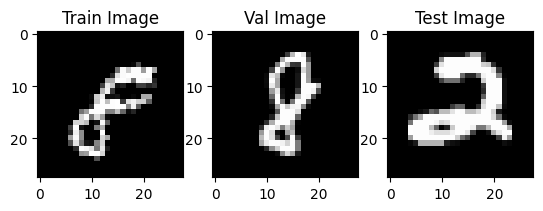

In [90]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [92]:
train_dataloader=DataLoader(dataset=train_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True)
val_dataloader=DataLoader(dataset=val_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True)
test_dataloader=DataLoader(dataset=test_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=False)

In [103]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),betas=ADAM_BETA,lr=LEARNING_RATE,weight_decay=ADAM_WEIGHT_DECAY )
start=timeit.default_timer()
for epoch in tqdm(range(EPOCHS),position=0,leave=True):
    model.train()
    train_labels=[]
    train_preds=[]
    train_running_loss=0
    for idx, img_label in enumerate(tqdm(train_dataloader,position=0,leave=True)):
        img=img_label["image"].float().to(device)
        label=img_label["label"].type(torch.uint8).to(device)
        y_pred=model(img)
        y_pred_label=torch.argmax(y_pred,dim=1)
        
        train_labels.extend(label.cpu().detach())
        
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss=criterion(y_pred,label)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_running_loss+=loss.item()
        
    train_loss=train_running_loss/(idx+1)
    
    
    model.eval()
    
    val_label=[]
    val_preds=[]
    val_running_loss=0
    
    with torch.no_grad():
        for idx,img_label in enumerate(tqdm(val_dataloader,position=0,leave=True)):
            img=img_label["image"].float().to(device)
            label=img_label["label"].type(torch.uint8).to(device)
            y_pred=model(img)
            y_pred_label=torch.argmax(y_pred,dim=1)
            
            val_label.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            loss=criterion(y_pred,label)
        
        
            
            val_running_loss+=loss.item()
            
        val_loss=val_running_loss/(idx+1)
        print("-"*30)
        print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
        print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
        print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
        print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_label) if x == y) / len(val_label):.4f}")
        print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")
        
            
    

100%|██████████| 9/9 [00:00<00:00,  9.85it/s]


------------------------------
Train Loss EPOCH 1: 1.4035
Valid Loss EPOCH 1: 1.2015


  2%|▎         | 1/40 [00:23<14:57, 23.00s/it]

Train Accuracy EPOCH 1: 0.5582
Valid Accuracy EPOCH 1: 0.6574
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


------------------------------
Train Loss EPOCH 2: 1.2565
Valid Loss EPOCH 2: 1.1044


  5%|▌         | 2/40 [00:46<14:46, 23.34s/it]

Train Accuracy EPOCH 2: 0.6349
Valid Accuracy EPOCH 2: 0.7079
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.65it/s]


------------------------------
Train Loss EPOCH 3: 1.1475
Valid Loss EPOCH 3: 1.0051


  8%|▊         | 3/40 [01:09<14:15, 23.12s/it]

Train Accuracy EPOCH 3: 0.6830
Valid Accuracy EPOCH 3: 0.7500
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.00it/s]


------------------------------
Train Loss EPOCH 4: 1.0547
Valid Loss EPOCH 4: 0.9163


 10%|█         | 4/40 [01:32<13:49, 23.04s/it]

Train Accuracy EPOCH 4: 0.7128
Valid Accuracy EPOCH 4: 0.7740
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.98it/s]


------------------------------
Train Loss EPOCH 5: 0.9725
Valid Loss EPOCH 5: 0.8830


 12%|█▎        | 5/40 [01:55<13:24, 23.00s/it]

Train Accuracy EPOCH 5: 0.7410
Valid Accuracy EPOCH 5: 0.7836
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.93it/s]


------------------------------
Train Loss EPOCH 6: 0.9078
Valid Loss EPOCH 6: 0.7814


 15%|█▌        | 6/40 [02:18<13:10, 23.24s/it]

Train Accuracy EPOCH 6: 0.7575
Valid Accuracy EPOCH 6: 0.8050
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.97it/s]


------------------------------
Train Loss EPOCH 7: 0.8536
Valid Loss EPOCH 7: 0.7265


 18%|█▊        | 7/40 [02:41<12:44, 23.15s/it]

Train Accuracy EPOCH 7: 0.7708
Valid Accuracy EPOCH 7: 0.8276
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


------------------------------
Train Loss EPOCH 8: 0.7969
Valid Loss EPOCH 8: 0.6769


 20%|██        | 8/40 [03:04<12:19, 23.10s/it]

Train Accuracy EPOCH 8: 0.7926
Valid Accuracy EPOCH 8: 0.8433
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.99it/s]


------------------------------
Train Loss EPOCH 9: 0.7489
Valid Loss EPOCH 9: 0.6421


 22%|██▎       | 9/40 [03:27<11:54, 23.03s/it]

Train Accuracy EPOCH 9: 0.8063
Valid Accuracy EPOCH 9: 0.8460
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


------------------------------
Train Loss EPOCH 10: 0.7120
Valid Loss EPOCH 10: 0.6140


 25%|██▌       | 10/40 [03:51<11:37, 23.24s/it]

Train Accuracy EPOCH 10: 0.8151
Valid Accuracy EPOCH 10: 0.8495
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.96it/s]


------------------------------
Train Loss EPOCH 11: 0.6717
Valid Loss EPOCH 11: 0.5497


 28%|██▊       | 11/40 [04:14<11:10, 23.12s/it]

Train Accuracy EPOCH 11: 0.8283
Valid Accuracy EPOCH 11: 0.8721
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.92it/s]


------------------------------
Train Loss EPOCH 12: 0.6344
Valid Loss EPOCH 12: 0.5470


 30%|███       | 12/40 [04:37<10:47, 23.11s/it]

Train Accuracy EPOCH 12: 0.8375
Valid Accuracy EPOCH 12: 0.8767
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


------------------------------
Train Loss EPOCH 13: 0.6058
Valid Loss EPOCH 13: 0.5095


 32%|███▎      | 13/40 [05:00<10:23, 23.08s/it]

Train Accuracy EPOCH 13: 0.8470
Valid Accuracy EPOCH 13: 0.8757
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


------------------------------
Train Loss EPOCH 14: 0.5749
Valid Loss EPOCH 14: 0.4660


 35%|███▌      | 14/40 [05:24<10:06, 23.32s/it]

Train Accuracy EPOCH 14: 0.8538
Valid Accuracy EPOCH 14: 0.8862
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


------------------------------
Train Loss EPOCH 15: 0.5466
Valid Loss EPOCH 15: 0.4580


 38%|███▊      | 15/40 [05:47<09:41, 23.25s/it]

Train Accuracy EPOCH 15: 0.8620
Valid Accuracy EPOCH 15: 0.8888
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


------------------------------
Train Loss EPOCH 16: 0.5219
Valid Loss EPOCH 16: 0.4226


 40%|████      | 16/40 [06:10<09:16, 23.18s/it]

Train Accuracy EPOCH 16: 0.8671
Valid Accuracy EPOCH 16: 0.9000
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.78it/s]


------------------------------
Train Loss EPOCH 17: 0.5007
Valid Loss EPOCH 17: 0.4019


 42%|████▎     | 17/40 [06:33<08:53, 23.18s/it]

Train Accuracy EPOCH 17: 0.8716
Valid Accuracy EPOCH 17: 0.9038
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.83it/s]


------------------------------
Train Loss EPOCH 18: 0.4764
Valid Loss EPOCH 18: 0.3997


 45%|████▌     | 18/40 [06:57<08:35, 23.43s/it]

Train Accuracy EPOCH 18: 0.8769
Valid Accuracy EPOCH 18: 0.9069
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.79it/s]


------------------------------
Train Loss EPOCH 19: 0.4576
Valid Loss EPOCH 19: 0.3787


 48%|████▊     | 19/40 [07:20<08:10, 23.36s/it]

Train Accuracy EPOCH 19: 0.8815
Valid Accuracy EPOCH 19: 0.9117
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


------------------------------
Train Loss EPOCH 20: 0.4398
Valid Loss EPOCH 20: 0.3687


 50%|█████     | 20/40 [07:44<07:46, 23.31s/it]

Train Accuracy EPOCH 20: 0.8851
Valid Accuracy EPOCH 20: 0.9100
------------------------------


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


------------------------------
Train Loss EPOCH 21: 0.4234
Valid Loss EPOCH 21: 0.3324


 52%|█████▎    | 21/40 [08:07<07:25, 23.45s/it]

Train Accuracy EPOCH 21: 0.8884
Valid Accuracy EPOCH 21: 0.9186
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.73it/s]


------------------------------
Train Loss EPOCH 22: 0.4151
Valid Loss EPOCH 22: 0.3473


 55%|█████▌    | 22/40 [08:31<07:01, 23.40s/it]

Train Accuracy EPOCH 22: 0.8896
Valid Accuracy EPOCH 22: 0.9112
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


------------------------------
Train Loss EPOCH 23: 0.4032
Valid Loss EPOCH 23: 0.3158


 57%|█████▊    | 23/40 [08:54<06:36, 23.32s/it]

Train Accuracy EPOCH 23: 0.8923
Valid Accuracy EPOCH 23: 0.9221
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.88it/s]


------------------------------
Train Loss EPOCH 24: 0.3881
Valid Loss EPOCH 24: 0.3080


 60%|██████    | 24/40 [09:17<06:12, 23.26s/it]

Train Accuracy EPOCH 24: 0.8947
Valid Accuracy EPOCH 24: 0.9174
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.55it/s]


------------------------------
Train Loss EPOCH 25: 0.3816
Valid Loss EPOCH 25: 0.2938


 62%|██████▎   | 25/40 [09:41<05:52, 23.47s/it]

Train Accuracy EPOCH 25: 0.8962
Valid Accuracy EPOCH 25: 0.9243
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.71it/s]


------------------------------
Train Loss EPOCH 26: 0.3665
Valid Loss EPOCH 26: 0.2867


 65%|██████▌   | 26/40 [10:04<05:27, 23.40s/it]

Train Accuracy EPOCH 26: 0.9004
Valid Accuracy EPOCH 26: 0.9226
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.63it/s]


------------------------------
Train Loss EPOCH 27: 0.3529
Valid Loss EPOCH 27: 0.2727


 68%|██████▊   | 27/40 [10:27<05:03, 23.34s/it]

Train Accuracy EPOCH 27: 0.9027
Valid Accuracy EPOCH 27: 0.9279
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.77it/s]


------------------------------
Train Loss EPOCH 28: 0.3496
Valid Loss EPOCH 28: 0.2880


 70%|███████   | 28/40 [10:50<04:39, 23.30s/it]

Train Accuracy EPOCH 28: 0.9042
Valid Accuracy EPOCH 28: 0.9283
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.91it/s]


------------------------------
Train Loss EPOCH 29: 0.3374
Valid Loss EPOCH 29: 0.2736


 72%|███████▎  | 29/40 [11:14<04:18, 23.47s/it]

Train Accuracy EPOCH 29: 0.9071
Valid Accuracy EPOCH 29: 0.9290
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.84it/s]


------------------------------
Train Loss EPOCH 30: 0.3345
Valid Loss EPOCH 30: 0.2640


 75%|███████▌  | 30/40 [11:38<03:54, 23.40s/it]

Train Accuracy EPOCH 30: 0.9075
Valid Accuracy EPOCH 30: 0.9298
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


------------------------------
Train Loss EPOCH 31: 0.3182
Valid Loss EPOCH 31: 0.2622


 78%|███████▊  | 31/40 [12:01<03:29, 23.32s/it]

Train Accuracy EPOCH 31: 0.9100
Valid Accuracy EPOCH 31: 0.9271
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.89it/s]


------------------------------
Train Loss EPOCH 32: 0.3142
Valid Loss EPOCH 32: 0.2733


 80%|████████  | 32/40 [12:24<03:06, 23.25s/it]

Train Accuracy EPOCH 32: 0.9117
Valid Accuracy EPOCH 32: 0.9281
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.77it/s]


------------------------------
Train Loss EPOCH 33: 0.3036
Valid Loss EPOCH 33: 0.2689


 82%|████████▎ | 33/40 [12:48<02:43, 23.42s/it]

Train Accuracy EPOCH 33: 0.9152
Valid Accuracy EPOCH 33: 0.9290
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.75it/s]


------------------------------
Train Loss EPOCH 34: 0.2907
Valid Loss EPOCH 34: 0.2388


 85%|████████▌ | 34/40 [13:11<02:20, 23.36s/it]

Train Accuracy EPOCH 34: 0.9197
Valid Accuracy EPOCH 34: 0.9329
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.73it/s]


------------------------------
Train Loss EPOCH 35: 0.2876
Valid Loss EPOCH 35: 0.2395


 88%|████████▊ | 35/40 [13:34<01:56, 23.34s/it]

Train Accuracy EPOCH 35: 0.9190
Valid Accuracy EPOCH 35: 0.9319
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.90it/s]


------------------------------
Train Loss EPOCH 36: 0.2893
Valid Loss EPOCH 36: 0.2210


 90%|█████████ | 36/40 [13:57<01:33, 23.29s/it]

Train Accuracy EPOCH 36: 0.9172
Valid Accuracy EPOCH 36: 0.9374
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.87it/s]


------------------------------
Train Loss EPOCH 37: 0.2862
Valid Loss EPOCH 37: 0.2341


 92%|█████████▎| 37/40 [14:21<01:10, 23.45s/it]

Train Accuracy EPOCH 37: 0.9181
Valid Accuracy EPOCH 37: 0.9350
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.66it/s]


------------------------------
Train Loss EPOCH 38: 0.2743
Valid Loss EPOCH 38: 0.2200


 95%|█████████▌| 38/40 [14:44<00:46, 23.40s/it]

Train Accuracy EPOCH 38: 0.9217
Valid Accuracy EPOCH 38: 0.9388
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.74it/s]


------------------------------
Train Loss EPOCH 39: 0.2635
Valid Loss EPOCH 39: 0.2045


 98%|█████████▊| 39/40 [15:08<00:23, 23.37s/it]

Train Accuracy EPOCH 39: 0.9261
Valid Accuracy EPOCH 39: 0.9402
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.68it/s]


------------------------------
Train Loss EPOCH 40: 0.2666
Valid Loss EPOCH 40: 0.2185


100%|██████████| 40/40 [15:31<00:00, 23.28s/it]

Train Accuracy EPOCH 40: 0.9240
Valid Accuracy EPOCH 40: 0.9352
------------------------------
Training Time: 931.32s


In [104]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:07<00:00,  7.75it/s]


<Figure size 640x480 with 0 Axes>

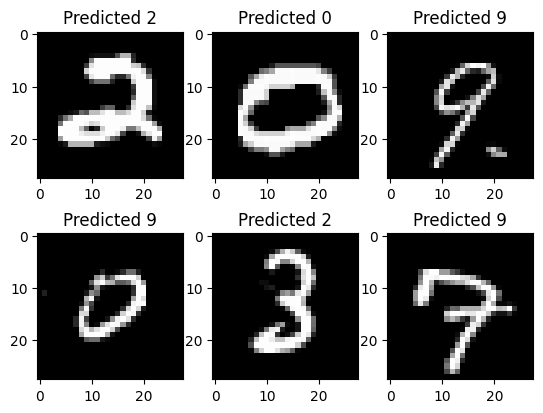

In [107]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [108]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,2
